In [1]:
# !/usr/bin/env python.
# -*- coding: utf-8 -*-

"""
Name:  filter and correct unreliable/reliable PWS

How to cite:
https://doi.org/10.5281/zenodo.4501920

Reference paper:

Bárdossy, A., Seidel, J., and El Hachem, A.: 
The use of personal weather station observations to improve precipitation estimation and interpolation,
Hydrol. Earth Syst. Sci., 25, 583–601, https://doi.org/10.5194/hess-25-583-2021, 2021.

"""

__author__ = "Abbas El Hachem", "Micha Eisele", "Jochen Seidel", "Andras Bardossy"
__copyright__ = 'Institut fuer Wasser- und Umweltsystemmodellierung - IWS'
__email__ = "abbas.el-hachem@iws.uni-stuttgart.de"

# =============================================================================

#from pathlib import Path

import os
import time
import timeit
import pyproj
import tqdm
import scipy.special
import xarray as xr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from pyproj import Transformer
from scipy.spatial import cKDTree
from scipy.stats import pearsonr as prs

from scipy import spatial as scsp
from scipy.stats import rankdata




In [2]:
import PWSpyqcFunctions as pyqc

### Golbal settings

In [3]:

import os
max_distance = 50000
prob=0.99
show_plot = True
min_req_ppt_vals = 2*30*24 # min nbr of hours
#main_dir = r"https://raw.githubusercontent.com/AbbasElHachem/pws-pyqc/main/OpenSense/Data/"
main_dir = r"https://raw.githubusercontent.com/AbbasElHachem/pws-pyqc/main/OpenSense/Data/"


   

### Read the input data

The PWS-pyqc Algorithm requires several years of reliable precipitation data from trustworthy sources (so called "Primary Stations"). As there are too few of such stations in the area around Amsterdam, times series for 20 random pixels of the gauge-adjusted KNMI radar product were chosen as primary data . 

#### Define the paths to the input data files

In [4]:
# AWS data from Netherlands
path_primary_network = os.path.join(main_dir, r"AWS_stns_data.csv")
path_primary_metadata = os.path.join(main_dir, r"AWS_stns_coords.csv")   
    

# 20 radar grid cell data from Amsterdam
path_primary_network2 = os.path.join(main_dir, r"Radar_grid_cell_vals.csv")
path_primary_metadata2 = os.path.join(main_dir, r"selected_radar_grid_lonlat.csv") 


# PWS hourly data
path_pws_data = os.path.join(main_dir, r"AMS_PWS_hourly_shifted.csv")   
path_pws_metadata = os.path.join(main_dir, r"AMS_metadata.csv")

#### Load the PWS and primay networek data

In [5]:
pyqc.

SyntaxError: invalid syntax (<ipython-input-5-50b34184159c>, line 1)

In [6]:
    # read primary network 1
print('Reading first primary network data')
in_primary_pcp = pyqc.read_pcp_csv_file(path_to_file=path_primary_network,
                           sep_type=';',
                           index_col=0)

df_prim_coords, prim_coords_xy = pyqc.read_metadata_csv_file(path_primary_metadata,
                                                           sep_type=';', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read primary network 2
print('Reading secondary primary network data')
in_primary_pcp_2 = pyqc.read_pcp_csv_file(path_to_file=path_primary_network2,
                           sep_type=';',
                           index_col=0)

df_prim_coords_2, prim_coords_xy_2 = read_metadata_csv_file(
            path_primary_metadata2,
            sep_type=',', index_col=0,)
df_prim_coords_2.index = in_primary_pcp_2.columns

# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pyqc.read_pcp_csv_file(
        path_to_file=path_pws_data,
                           sep_type=';',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = read_metadata_csv_file(
        path_to_file=path_pws_metadata,
                           sep_type=',',
                           index_col=0)
df_pws_coords.index = df_pws_pcp_hourly.columns
    
    
    

Reading first primary network data


AttributeError: 'Proj' object has no attribute 'transform'

### Plot the locations of the stations 

In [8]:
print('Plotting locations of all data')

pyqc.plot_pws_prim_netz_loc(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)
print('Plotting locations of data in and around Amsterdam')

pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)
    


Plotting locations of all data


NameError: name 'df_pws_coords' is not defined

The fist QC-filter of PWS-pyqc is based on indicator correlation patterns of the primary network (cf. Bárdossy el al. 2021). First, the data of the primary network are converted to 1 and 0 based on a threshhold, in this case the 99%-percentile. All values above this percentile are 1, all below 0. This indicator correaltion of the primay stations has a spatial structure, i.e. the correlaiton decreases with increasing distance


In [17]:
# PLOT indicator correlation values different networks
# calculate indicator correlation primary network
print('Calculating indicator correlation')
dist_prim, corr_prim = pyqc.calc_indic_corr_all_stns(
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values)

# calculate indicator correlation second primary network
dist_prim2, corr_prim2 = pyqc.calc_indic_corr_all_stns(
    coords_stns_xy=prim_coords_xy_2,
    pcp_vals=in_primary_pcp_2.values)

# claculate indicator correlation PWS-PWS
dist_pws, corr_pws = pyqc.calc_indic_corr_all_stns(
                    coords_stns_xy=pws_coords_xy,
                         pcp_vals=df_pws_pcp_hourly.values)

pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2)

Calculating indicator correlation


NameError: name 'prim_coords_xy' is not defined

As can be seen in the plot above, the primary stations have a certain dependence sturcture over distance. Most of the PWS as well, but there are also some PWS which do not follow this structure. When the indicator corrleation of a PWS next to a primary station is low, then it is likley that the PWS data are faulty.The first QC-filer pf PWS-pyqc now removes all PWS which do not show indicaotr correlations similiar to that of the reference data (primay stations).

In [18]:
# apply indicator filter

stn_in = pyqc.indicator_filter(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy_2,
                 prc_dwd=in_primary_pcp_2,
                     prob=0.99, max_distance=50000,
                     min_req_ppt_vals=2*24*30, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None,
                    tolerance=.99)



NameError: name 'pws_coords_xy' is not defined

In this case, 49 of 134 stations are removed because they deliver data that does not match what we would expect from the primary network.

In [27]:
pws_ids_accepted = df_pws_pcp_hourly.columns[np.where(stn_in==True)]
pws_ids_accepted

Index(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams12', 'ams13', 'ams14', 'ams15', 'ams17', 'ams18', 'ams19',
       'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams39', 'ams40',
       'ams43', 'ams47', 'ams51', 'ams52', 'ams53', 'ams54', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams71', 'ams72', 'ams75', 'ams78',
       'ams79', 'ams81', 'ams82', 'ams86', 'ams88', 'ams89', 'ams90', 'ams91',
       'ams94', 'ams95', 'ams96', 'ams98', 'ams100', 'ams101', 'ams102',
       'ams103', 'ams104', 'ams106', 'ams107', 'ams108', 'ams109', 'ams111',
       'ams113', 'ams114', 'ams115', 'ams117', 'ams118', 'ams120', 'ams123',
       'ams125', 'ams128', 'ams129', 'ams131', 'ams132', 'ams133', 'ams134'],
      dtype='object')

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 25.38it/s]


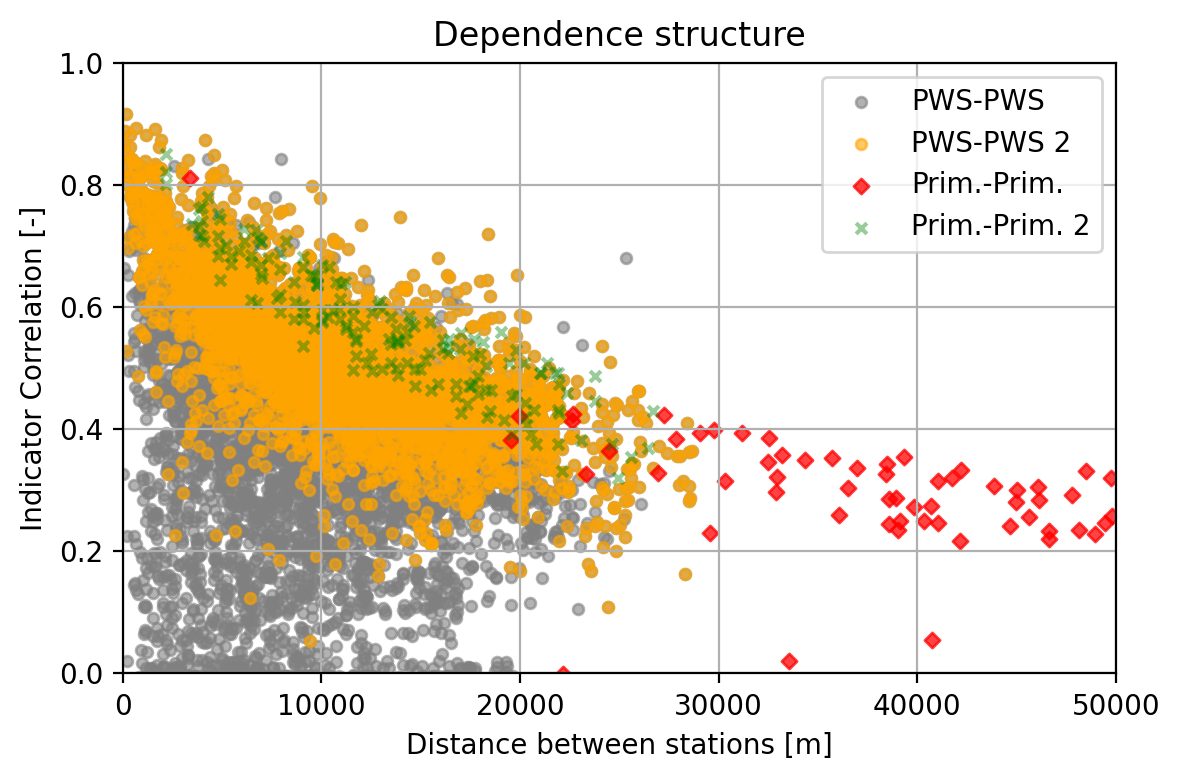

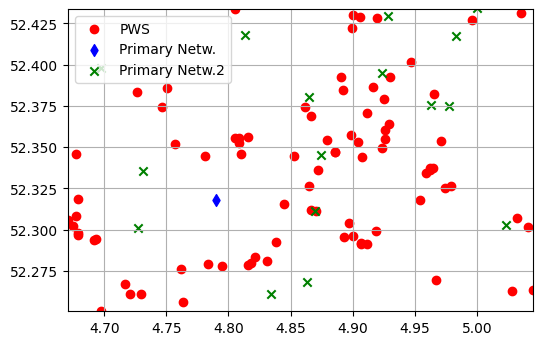

In [28]:
# claculate indicator correlation PWS-PWS
dist_pws_after, corr_pws_after = pyqc.calc_indic_corr_all_stns(
    coords_stns_xy=pws_coords_xy[np.where(stn_in==True)],
                         pcp_vals=df_pws_pcp_hourly.loc[:,pws_ids_accepted].values)

pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                    dist_pws=dist_pws,
                   corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2,
               dist_pws_after=dist_pws_after,
               corr_pws_after=corr_pws_after)

pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.loc[pws_ids_accepted, 'lon'],
                           lat_pws=df_pws_coords.loc[pws_ids_accepted, 'lat'],
                          lon_prim1=df_prim_coords.lon,
                           lat_prim1=df_prim_coords.lat,
                          lon_prim2=df_prim_coords_2.lon,
                           lat_prim2=df_prim_coords_2.lat)

## Apply Bias Correction

The goal is to correct the PWS distribution function usind the distribution function of neighboring primary network stations. For more details see Bárdossy et al. (2021).


In [29]:
new_prc = pyqc.bias_correct(xy_net=pws_coords_xy,
                       prc_net=df_pws_pcp_hourly.values,
                       xy_prim=prim_coords_xy_2,
                       prc_prim=in_primary_pcp_2.values,
                           stn_in_bool=stn_in)

df_corrrected = pd.DataFrame(index=df_pws_pcp_hourly.index,
                              data=new_prc,
                              columns =df_pws_pcp_hourly.columns)

  0%|                                                                                          | 0/134 [00:00<?, ?it/s]<ipython-input-14-777a176bfab0>:32: RuntimeWarning: invalid value encountered in multiply
  c = Sill * 1.0 / fac2 * fac1**v * Kv(v, fac1)
100%|███████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 451.45it/s]


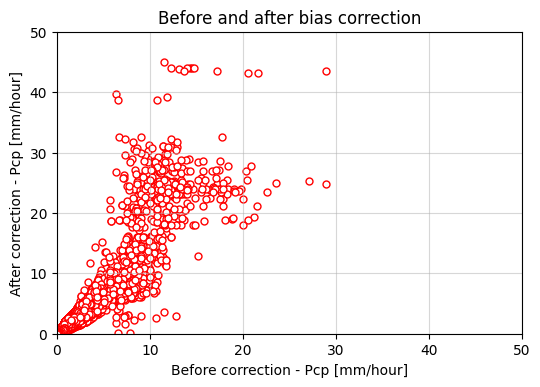

In [30]:
# plot results after bias correction
plt.figure(dpi=100)
plt.title('Before and after bias correction')
plt.scatter(
    df_pws_pcp_hourly.iloc[:, stn_in].values,
    df_corrrected.iloc[:, stn_in].values,
    edgecolor='r',
    facecolor='w',
    marker='o',
s=25)



plt.plot([0, max(df_pws_pcp_hourly.values.max(),
    df_corrrected.values.max())],
        [0, max(df_pws_pcp_hourly.values.max(),
    df_corrrected.values.max())],
        c='grey',
        linestyle='-.')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.xlabel('Before correction - Pcp [mm/hour]')
plt.ylabel('After correction - Pcp [mm/hour]')
plt.grid(alpha=0.5)     
        
